In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import wrf 
import cartopy
import cartopy.crs as ccrs
from metpy.plots import USCOUNTIES
import pandas as pd
from scipy.stats import gaussian_kde

mpl.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# To load the colormap from the JSON file and recreate it
import json
from matplotlib.colors import ListedColormap
with open('/data/keeling/a/xx24/colormap.json', 'r') as json_file:
    loaded_colors = json.load(json_file)
    loaded_colors = [(r / 255, g / 255, b / 255) for r, g, b in loaded_colors]
    cmap = ListedColormap(loaded_colors)

In [3]:
from netCDF4 import Dataset
wrfout = Dataset('/data/keeling/a/jcurtis2/d/bridges2_big_run/aerosols_d01_2010-06-17_00:00:00', "r", format="NETCDF4")
wrfinput = Dataset('/data/keeling/a/jcurtis2/d/bridges2_big_run/wrfinput_d01', "r", format="NETCDF4")
ozone = wrf.getvar(wrfout, "o3")
lats, lons = wrf.latlon_coords(ozone)
lats = wrf.to_np(lats)
lons = wrf.to_np(lons)

In [4]:
land_mask = wrfinput['LANDMASK'][0,:,:].T

In [5]:
def nc_shape(var):
    da = xr.DataArray(
        data=var.T,
        dims=["south_north", "west_east"],
        coords=dict(
            lon=(["south_north", "west_east"], lons),
            lat=(["south_north", "west_east"], lats),
        ),
        attrs=dict(
            description="var",
            units="1",
        ),
    )
    return da

In [6]:
def rel_err(var_cs, var_vs):
    if np.any(var_vs == 0):
        result = np.zeros_like(var_cs)
    else:
        result = (var_cs - var_vs) / var_vs
    return - result*100

In [7]:
poa_mass_fracs     = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/oc_mass_fracs_all',sep=',',header=None)
poa_mass_fracs_1km = pd.read_csv('/data/keeling/a/xx24/d/proj_film/poa_soa/poa_mass_frac_00_1km',sep=',',header=None)
soa_mass_fracs     = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/soa_mass_fracs_all',sep=',',header=None)
soa_mass_fracs_1km = pd.read_csv('/data/keeling/a/xx24/d/proj_film/poa_soa/soa_mass_frac_00_1km',sep=',',header=None)

oa_mass_fracs = poa_mass_fracs + soa_mass_fracs
oa_mass_fracs_1km = poa_mass_fracs_1km + soa_mass_fracs_1km

oa_mass_fracs_map = nc_shape(oa_mass_fracs*land_mask)
oa_mass_fracs_1km_map = nc_shape(oa_mass_fracs_1km*land_mask)

poa_mass_frac_large = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/oc_mass_fracs_large',sep=',',header=None)
poa_mass_frac_small = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/oc_mass_fracs_small',sep=',',header=None)
soa_mass_frac_large = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/soa_mass_fracs_large',sep=',',header=None)
soa_mass_frac_small = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/soa_mass_fracs_small',sep=',',header=None)

poa_mass_frac_1km_large = pd.read_csv('/data/keeling/a/xx24/d/proj_film/poa_soa/poa_mass_frac_00_1km_large',sep=',',header=None)
poa_mass_frac_1km_small = pd.read_csv('/data/keeling/a/xx24/d/proj_film/poa_soa/poa_mass_frac_00_1km_small',sep=',',header=None)
soa_mass_frac_1km_large = pd.read_csv('/data/keeling/a/xx24/d/proj_film/poa_soa/soa_mass_frac_00_1km_large',sep=',',header=None)
soa_mass_frac_1km_small = pd.read_csv('/data/keeling/a/xx24/d/proj_film/poa_soa/soa_mass_frac_00_1km_small',sep=',',header=None)

oa_mass_fracs_large = poa_mass_frac_large + soa_mass_frac_large
oa_mass_fracs_small = poa_mass_frac_small + soa_mass_frac_small
oa_mass_fracs_1km_large = poa_mass_frac_1km_large + soa_mass_frac_1km_large
oa_mass_fracs_1km_small = poa_mass_frac_1km_small + soa_mass_frac_1km_small

/tmp/ipykernel_3162463/3516083915.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


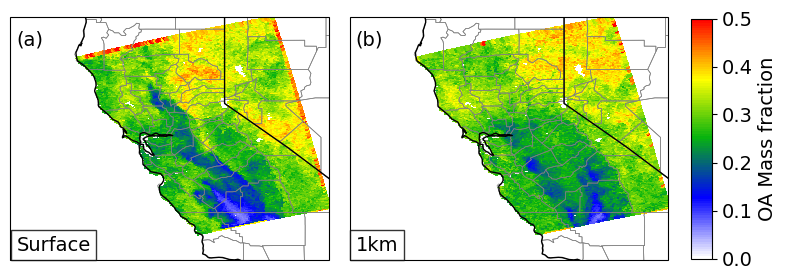

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

#00 surface oa
axes[0].set_frame_on(False)
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)
axes[0] = fig.add_subplot(121, projection=ccrs.PlateCarree())
axes[0].set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
axes[0].add_feature(USCOUNTIES.with_scale('20m'), edgecolor='grey', linewidth=0.5)
axes[0].add_feature(cartopy.feature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none'), edgecolor='black')
axes[0].coastlines(resolution='50m', color='black', linewidth=1)
axes[0].pcolormesh(lons, lats, oa_mass_fracs_map, vmin=0, vmax=0.5, transform=ccrs.PlateCarree(), edgecolor='face', antialiased=False, cmap=cmap)
axes[0].annotate('(a)', xy=(0.02, 0.95),xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')
axes[0].text(0.02, 0.02, 'Surface', transform=axes[0].transAxes, ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))

# 1km oa
axes[1].set_frame_on(False)
axes[1].xaxis.set_visible(False)
axes[1].yaxis.set_visible(False)
axes[1] = fig.add_subplot(122, projection=ccrs.PlateCarree())
axes[1].set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
axes[1].add_feature(USCOUNTIES.with_scale('20m'), edgecolor='grey', linewidth=0.5)
axes[1].add_feature(cartopy.feature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none'), edgecolor='black')
axes[1].coastlines(resolution='50m', color='black', linewidth=1)
im1 = axes[1].pcolormesh(lons, lats, oa_mass_fracs_1km_map, vmin=0, vmax=0.5, transform=ccrs.PlateCarree(), edgecolor='face', antialiased=False, cmap=cmap)
position1 = fig.add_axes([1.003, 0.1, 0.03, 0.8])  # position (left, bottom, width, height)
cbar = plt.colorbar(im1, ax=axes[1], cax=position1, orientation='vertical')
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.set_label_position('bottom')
cbar.set_label('OA Mass fraction')
axes[1].annotate('(b)', xy=(0.02, 0.95),xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')
axes[1].text(0.02, 0.02, '1km', transform=axes[1].transAxes, ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))

plt.tight_layout()
# plt.savefig('/data/keeling/a/xx24/d/proj_film/oa_mass_frac_00.pdf', bbox_inches='tight',dpi=300)

In [14]:
# Calculate the absolute difference between 1km and surface OA mass fractions
diff_abs = oa_mass_fracs_1km - oa_mass_fracs

# Calculate the relative difference (%) between 1km and surface OA mass fractions
diff_rel_pct = 100 * (oa_mass_fracs_1km - oa_mass_fracs) / oa_mass_fracs

# Print the overall mean differences (averaged over all grid points)
print("Mean absolute difference:", diff_abs.mean().mean())
print("Mean relative difference (%):", diff_rel_pct.mean().mean())

Mean absolute difference: 0.011433527984175683
Mean relative difference (%): 13.89279610427471


In [9]:
ccn_cs = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_cs_all', sep=',', header=None)
ccn_cs_large = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_cs_large', sep=',', header=None)
ccn_cs_small = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_cs_small', sep=',', header=None)

ccn_vs = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_vs_all', sep=',', header=None)
ccn_vs_large = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_vs_large', sep=',', header=None)
ccn_vs_small = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_vs_small', sep=',', header=None)

ccn_cs_1km = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_cs_all_1km', sep=',', header=None)
ccn_cs_large_1km = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_cs_large_1km', sep=',', header=None)
ccn_cs_small_1km = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_cs_small_1km', sep=',', header=None)

ccn_vs_1km = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_vs_all_1km', sep=',', header=None)
ccn_vs_large_1km = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_vs_large_1km', sep=',', header=None)
ccn_vs_small_1km = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_vs_small_1km', sep=',', header=None)

ccn_error           = rel_err(ccn_cs,           ccn_vs)
ccn_large_error     = rel_err(ccn_cs_large,     ccn_vs_large)
ccn_small_error     = rel_err(ccn_cs_small,     ccn_vs_small)
ccn_1km_error       = rel_err(ccn_cs_1km,       ccn_vs_1km)
ccn_large_1km_error = rel_err(ccn_cs_large_1km, ccn_vs_large_1km)
ccn_small_1km_error = rel_err(ccn_cs_small_1km, ccn_vs_small_1km)

ccn_error_map = nc_shape(ccn_error*land_mask)
ccn_large_error_map = nc_shape(ccn_large_error*land_mask)
ccn_small_error_map = nc_shape(ccn_small_error*land_mask)
ccn_1km_error_map = nc_shape(ccn_1km_error*land_mask)
ccn_large_1km_error_map = nc_shape(ccn_large_1km_error*land_mask)
ccn_small_1km_error_map = nc_shape(ccn_small_1km_error*land_mask)

In [10]:
def kde(var, error_var):
    
    array = [(var*land_mask).values.ravel(), (error_var*land_mask).values.ravel()]
    
    layer_error_array = np.array(array)
    
    # 筛选出所有非零点
    non_zero_indices = np.any(layer_error_array != 0, axis=0)
    filtered_data = layer_error_array[:, non_zero_indices]

    # 对过滤后的数据进行核密度估计
    scatter_avg = np.vstack(filtered_data)
    scatter_avg_z = gaussian_kde(scatter_avg)(scatter_avg)
    
    return filtered_data[0], filtered_data[1], scatter_avg_z

In [11]:
oa_x,       oa_y,       oa_z       = kde(oa_mass_fracs,       ccn_error)
oa_small_x, oa_small_y, oa_small_z = kde(oa_mass_fracs_small, ccn_small_error)
oa_large_x, oa_large_y, oa_large_z = kde(oa_mass_fracs_large, ccn_large_error)


oa_x_1km,       oa_y_1km,       oa_z_1km       = kde(oa_mass_fracs_1km,       ccn_1km_error)
oa_small_x_1km, oa_small_y_1km, oa_small_z_1km = kde(oa_mass_fracs_1km_small, ccn_small_1km_error)
oa_large_x_1km, oa_large_y_1km, oa_large_z_1km = kde(oa_mass_fracs_1km_large, ccn_large_1km_error)

kde_vmin = min(oa_z.min(), oa_small_z.min(), oa_large_z.min() ,oa_z_1km.min() ,oa_small_z_1km.min() ,oa_large_z_1km.min())
kde_vmax = max(oa_z.max(), oa_small_z.max(), oa_large_z.max(), oa_z_1km.max() ,oa_small_z_1km.max() ,oa_large_z_1km.max())
norm = mpl.colors.Normalize(vmin=kde_vmin, vmax=kde_vmax)

/tmp/ipykernel_3162463/1792928137.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


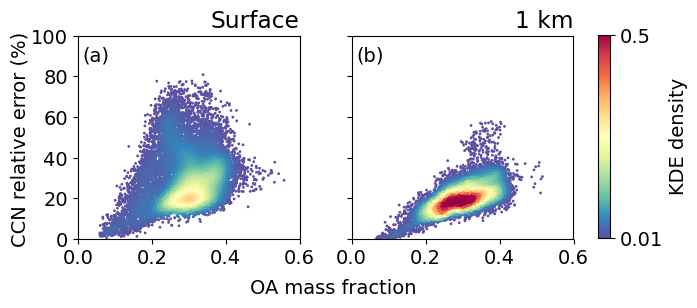

In [12]:
fig, axes = plt.subplots(1,2,figsize=(6,3), sharex=True, sharey=True)

sc = axes[0].scatter(oa_x, oa_y, marker='o', s=1, c=oa_z, cmap='Spectral_r',  norm=norm)
axes[0].annotate('(a)', xy=(0.02, 0.95),xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')

axes[1].scatter(oa_x_1km, oa_y_1km, marker='o', s=1, c=oa_z_1km, cmap='Spectral_r',  norm=norm)
axes[1].annotate('(b)', xy=(0.02, 0.95),xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')

axes[0].set_xlim(0, 0.6)
axes[0].set_ylim(0, 100)

axes[0].set_title('Surface', loc='right')
axes[1].set_title('1 km', loc='right')

fig.text(0, 0.5, 'CCN relative error (%)', va='center', rotation='vertical')
fig.text(0.4, 0, 'OA mass fraction', va='center', rotation='horizontal')


cax = fig.add_axes([0.98, 0.17, 0.02, 0.675])
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label('KDE density')

disp_min, disp_max = 0.01, 0.5

sc.set_clim(disp_min, disp_max)   # 修改 mappable 的 vmin/vmax
cbar.update_normal(sc)            # 让 colorbar 跟新
cbar.set_ticks([disp_min, disp_max])
cbar.set_ticklabels([f'{disp_min}', f'{disp_max}'])

plt.tight_layout()
plt.savefig('/data/keeling/a/xx24/d/proj_film/coverage_oa_kde_00_all.pdf', bbox_inches='tight',dpi=300)

/tmp/ipykernel_3162463/2383665337.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


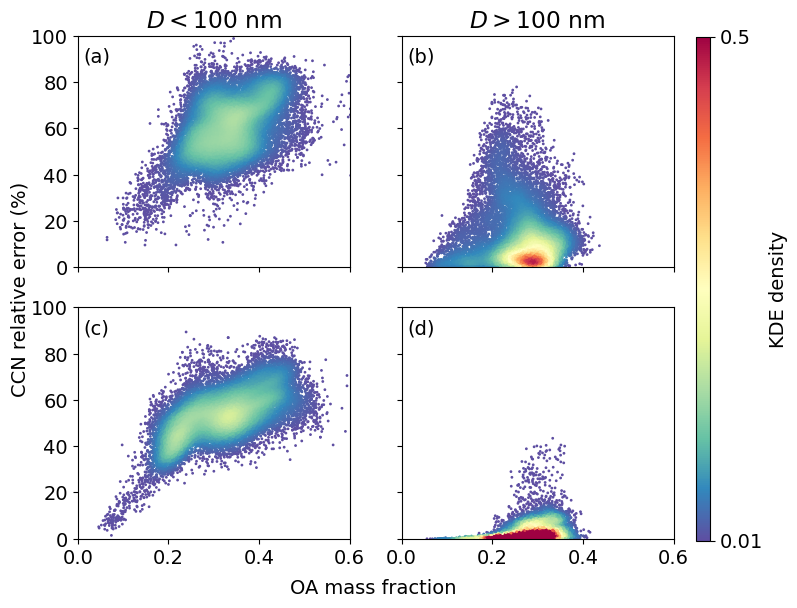

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)

# 第一个 scatter，保存 mappable
sc = axes[0,0].scatter(oa_small_x, oa_small_y, s=1, c=oa_small_z, cmap='Spectral_r', norm=norm)
axes[0, 0].annotate('(a)', xy=(0.02, 0.95), xycoords='axes fraction',
                 ha='left', va='top')
axes[0, 0].set_title(r'$D<100~\mathrm{nm}$')

axes[0, 1].scatter(oa_large_x, oa_large_y, s=1, c=oa_large_z, cmap='Spectral_r', norm=norm)
axes[0, 1].annotate('(b)', xy=(0.02, 0.95), xycoords='axes fraction',
                 ha='left', va='top')
axes[0, 1].set_title(r'$D>100~\mathrm{nm}$')

axes[0, 0].set_xlim(0, 0.6)
axes[0, 0].set_ylim(0, 100)

axes[1, 0].scatter(oa_small_x_1km, oa_small_y_1km, marker='o', s=1, c=oa_small_z_1km, cmap='Spectral_r', norm=norm)
axes[1, 0].annotate('(c)', xy=(0.02, 0.95),xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')

axes[1, 1].scatter(oa_large_x_1km, oa_large_y_1km, marker='o', s=1, c=oa_large_z_1km, cmap='Spectral_r', norm=norm)
axes[1, 1].annotate('(d)', xy=(0.02, 0.95),xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')

fig.text(0.4, 0, 'OA mass fraction', va='center', rotation='horizontal')
fig.text(0, 0.5, 'CCN relative error (%)', va='center', rotation='vertical')

cax = fig.add_axes([0.98, 0.08, 0.02, 0.84])
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label('KDE density')

disp_min, disp_max = 0.01, 0.5
sc.set_clim(disp_min, disp_max)   # 修改 mappable 的 vmin/vmax
cbar.update_normal(sc)            # 让 colorbar 跟新
cbar.set_ticks([disp_min, disp_max])
cbar.set_ticklabels([f'{disp_min}', f'{disp_max}'])

plt.tight_layout()
plt.savefig('/data/keeling/a/xx24/d/proj_film/coverage_oa_kde_00_large_small.pdf', bbox_inches='tight',dpi=300)